# Quick scripting for XPS-tool

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Embedded imports
import os, sys
import math
import matplotlib.pyplot as plt

In [3]:
# Third party imports
import numpy as np
import pandas as pd

In [4]:
# Temporary solution for local imports
sys.path.append('..')
from xpstool import scientahandler as scih
from xpstool import specshandler as speh
from xpstool.region import Region

In [5]:
# Constants
al_k_alpha = 1486.61 # Al K-alpha photon source energy
p22_energy_3800 = 3800 # Photon energy from the p22 beamline
p22_energy_4600 = 4600 # Photon energy from the p22 beamline

## Nanolab data (Al K-alpha radiation 1486.61 eV)

## Petra III, P22 beamline (Scienta analyzer)

In [14]:
# ---SCIENTA DATA---
# Full path to data files
data_path = "/Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/"
# Folders to add to the full path above 
data_folders = [
    "Data"
]
# Output folders
output_folders = [
    "ProcessedData"
]

In [15]:
# List of all directories (combine the full path with specified folders)
all_dirs = ["".join([data_path, data_folder]) for data_folder in data_folders]
all_output_dirs = ["".join([data_path, output_folder]) for output_folder in output_folders]

# Iterating through directories displaying existing files
all_files = []
for i, dirname in enumerate(sorted(all_dirs)):
    if i > 0: # Just to make it prettier (no empty line before the first output)
        print() # Otherwise, add an empty line to separate outputs
    print(f"all_dirs[{i}]: {dirname}")
    
    # Iterating through the list of files inside the directory. Files are sorted
    # according to the last _number value in their name using lambda function
    files = []
    for j, file in enumerate(sorted(os.listdir(all_dirs[i]))):
        if file.endswith(".txt"):                         
            files.append(file)
            print(f"---> all_files[{i}][{j}]: {file}")
    all_files.append(files)

all_dirs[0]: /Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/Data
---> all_files[0][1]: 0000.txt
---> all_files[0][4]: 0001.txt
---> all_files[0][7]: 0002.txt
---> all_files[0][10]: 0003.txt
---> all_files[0][13]: 0004.txt
---> all_files[0][16]: 0005.txt
---> all_files[0][19]: 0006.txt
---> all_files[0][22]: 0007.txt
---> all_files[0][25]: 0008.txt
---> all_files[0][28]: 0009.txt
---> all_files[0][31]: 0010.txt
---> all_files[0][34]: 0011.txt
---> all_files[0][37]: 0012.txt
---> all_files[0][40]: 0013.txt
---> all_files[0][43]: 0014.txt
---> all_files[0][46]: 0015.txt
---> all_files[0][49]: 0016.txt
---> all_files[0][52]: 0017.txt
---> all_files[0][55]: 0018.txt
---> all_files[0][58]: 0019.txt
---> all_files[0][61]: 0020.txt
---> all_files[0][64]: 0021.txt
---> all_files[0][67]: 0022.txt
---> all_files[0][70]: 0023.txt
---> all_files[0][73]: 0024.txt
---> all_files[0][76]: 0025.txt
---> all_files[0][79]: 0026.txt
---> all_files[0][82]:


Region Name: Rh3d_4600
Lens Mode: T_HiPPHAXPES
Pass Energy: 100
Number of Sweeps: 3
Excitation Energy: 4600
Energy Scale: Binding
Acquisition Mode: Swept
Energy Unit: Binding
Center Energy: 313.5
Low Energy: 320.0
High Energy: 307.0
Energy Step: 0.05
Step Time: 129
Detector First X-Channel: 1
Detector Last X-Channel: 512
Detector First Y-Channel: 1
Detector Last Y-Channel: 460
Number of Slices: 1
File: D:\Data\2018_11_RhFebeamtime\0123.pxt,.ibw,.txt
Sequence: D:\SES_1.7.2_Win64_Package\SES_1.7.2_Win64\Sequences\factory.seq
Spectrum Name: Rh3d_4600
Instrument: HiPP-2 10kV-9862
Location: 
User: 
Sample: 
Comments: Testing the voltage output;
Date: 2018-11-19
Time: 10:57:31
Time per Spectrum Channel: 66.177
DetectorMode: ADC


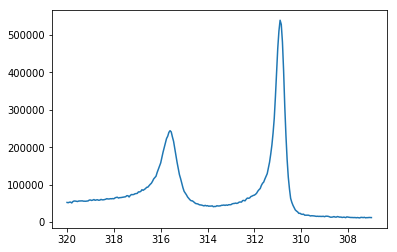

In [16]:
# Plot preview of a Scienta.txt file
scans = scih.importScientaFile("/".join([all_dirs[0], all_files[0][123]]))
output_dir = all_output_dirs[0]

#%matplotlib qt # Plotting in a separate interactive window
if len(scans) == 1:
    scans[0].invertEnergyScale(p22_energy_4600)
    print(scans[0])
    plt.plot(scans[0].getData()["energy"], scans[0].getData()["counts"])
    plt.gca().invert_xaxis()
else:
    fig, axs = plt.subplots(int(math.ceil(len(scans)/2)),2)
    for i, scan in enumerate(scans):
        axs[i].plot(scan.getData()["energy"], scan.getData()["counts"])
        axs[i].invert_xaxis()

## Saving regions

In [91]:
for scan in scans:
    # Getting the name of the original file from the corresponding info entry
    name = scan.getInfo()["File"].rpartition("\\")[2].split(".")[0]
    name = ".".join([name, "csv"])
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    scans[0].saveCSV("/".join([output_dir, name]))

## Fitting Fermi levels

In [92]:
region = Region.readCSV("/".join([output_dir, "0123_5.csv"]))
print(region)


Region Name: Rh3d_4600
Lens Mode: T_HiPPHAXPES
Pass Energy: 100
Number of Sweeps: 3
Excitation Energy: 4600
Energy Scale: Binding
Acquisition Mode: Swept
Energy Unit: Binding
Center Energy: 313.5
Low Energy: 320.0
High Energy: 307.0
Energy Step: 0.05
Step Time: 129
Detector First X-Channel: 1
Detector Last X-Channel: 512
Detector First Y-Channel: 1
Detector Last Y-Channel: 460
Number of Slices: 1
File: D:\Data\2018_11_RhFebeamtime\0123.pxt,.ibw,.txt
Sequence: D:\SES_1.7.2_Win64_Package\SES_1.7.2_Win64\Sequences\factory.seq
Spectrum Name: Rh3d_4600
Instrument: HiPP-2 10kV-9862
Location: 
User: 
Sample: 
Comments: Testing the voltage output;
Date: 2018-11-19
Time: 10:57:31
Time per Spectrum Channel: 66.177
DetectorMode: ADC


In [93]:
region.getFlags()

['False', 'True', 'False']